# Calculate and visualize seasonal variation in embeddings

This notebook walks through the process of extracting embeddings for a single patch of each example and plotting the cosine similarity of each time step with respect to the previous step. This is plotted and aggregated by land cover class to visualize and quantify how different models show seasonal variation in embeddings.

In [1]:
# imports
from gelos.embedding_extraction import extract_embeddings
from gelos.embedding_generation import perturb_args_to_string
import geopandas as gpd
import yaml
from gelos.config import PROJ_ROOT, PROCESSED_DATA_DIR, DATA_VERSION, RAW_DATA_DIR
from gelos.config import REPORTS_DIR, FIGURES_DIR
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

2025-12-11 22:19:00.378 | INFO     | gelos.config:<module>:16 - PROJ_ROOT path is: /app
/opt/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
/opt/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


## Set parameters for embedding extraction

In [2]:
n_timesteps = 4
model_name = "prithvieov2300"

## Extract embeddings and calculate cosine similarity for each time step

In [3]:
yaml_name = f"{model_name}_noperturb.yaml"
yaml_path = PROJ_ROOT / "gelos" / "configs" / yaml_name
with open(yaml_path, "r") as f:
    yaml_config = yaml.safe_load(f)
print(yaml.dump(yaml_config))

data_root = RAW_DATA_DIR / DATA_VERSION
chip_gdf = gpd.read_file(data_root / 'gelos_chip_tracker.geojson')
figures_dir = FIGURES_DIR / DATA_VERSION
figures_dir.mkdir(exist_ok=True, parents=True)

model_name = yaml_config['model']['init_args']['model']
model_title = yaml_config['model']['title']
embedding_extraction_strategies = yaml_config['embedding_extraction_strategies']
perturb = yaml_config['data']['init_args'].get('perturb_bands', None)
perturb_string = perturb_args_to_string(perturb)
output_dir = PROCESSED_DATA_DIR / DATA_VERSION / model_name / perturb_string

embeddings_directories = [item for item in output_dir.iterdir() if item.is_dir()]

data:
  class_path: gelos.gelosdatamodule.GELOSDataModule
  init_args:
    bands:
      S2L2A:
      - BLUE
      - GREEN
      - RED
      - NIR_NARROW
      - SWIR_1
      - SWIR_2
    batch_size: 1
    num_workers: 0
    transform:
    - class_path: terratorch.datasets.transforms.FlattenTemporalIntoChannels
    - class_path: albumentations.pytorch.transforms.ToTensorV2
    - class_path: terratorch.datasets.transforms.UnflattenTemporalFromChannels
      init_args:
        n_timesteps: 4
embedding_extraction_strategies:
  All Patches from April to June:
  - start: 37
    step: 1
    stop: 73
  All Steps of Middle Patch:
  - start: 19
    step: 36
    stop: null
  CLS Token:
  - start: 0
    step: 1
    stop: 1
model:
  class_path: terratorch.tasks.EmbeddingGenerationTask
  init_args:
    embed_file_key: filename
    embedding_pooling: null
    has_cls: true
    layers:
    - -1
    model: prithvi_eo_v2_300
    model_args:
      bands:
      - BLUE
      - GREEN
      - RED
      - NIR

In [4]:
embeddings_directory = embeddings_directories[0]
print(embeddings_directory)
embedding_layer = embeddings_directory.stem
extraction_strategy = "All Steps of Middle Patch"
slice_args = embedding_extraction_strategies[extraction_strategy]

model_title_lower = model_title.replace(" ", "").lower()
extraction_strategy_lower = extraction_strategy.replace(" ", "").lower()
embedding_layer_lower = embedding_layer.replace("_", "").lower()
csv_path = output_dir / f"{model_title_lower}_{perturb_string}_{extraction_strategy_lower}_{embedding_layer_lower}_temporalsimilarity.csv"

/app/data/processed/v0.50.0/prithvi_eo_v2_300/noperturb/layer_23


In [5]:
embeddings, chip_indices = extract_embeddings(
    embeddings_directory,
    slice_args=slice_args
    )


extracting embedding transformation into /app/data/processed/v0.50.0/prithvi_eo_v2_300/noperturb/prithvieov2300m_noperturb_allstepsofmiddlepatch_layer23_temporalsimilarity.csv


Processing embeddings: 60507it [03:27, 292.26it/s]
Processing embeddings: 60507it [03:27, 292.26it/s]


In [6]:
n_samples, flat_embedding_shape = embeddings.shape
embed_depth = int(flat_embedding_shape / n_timesteps)
embeddings_reshaped = embeddings.reshape(n_samples, n_timesteps, embed_depth)
previous_timesteps = np.roll(embeddings_reshaped, shift=1, axis=1)

In [7]:
cosine_similarities = np.array([
    cosine_similarity(embeddings_reshaped[i], previous_timesteps[i]).diagonal()
    for i in tqdm(range(n_samples))
])

100%|██████████| 60507/60507 [00:18<00:00, 3329.16it/s]


## Plot and aggregate according to land cover class

In [8]:
for t in range(n_timesteps):
    chip_gdf[f"temporalsimilarity_{t}"] = cosine_similarities[:, t]
colors_df = chip_gdf.groupby("category")['color'].describe()['top']
timestep_ranges = [
    "Jan-Mar",
    "Apr-Jun",
    "Jul-Sep",
    "Oct-Dec",
]

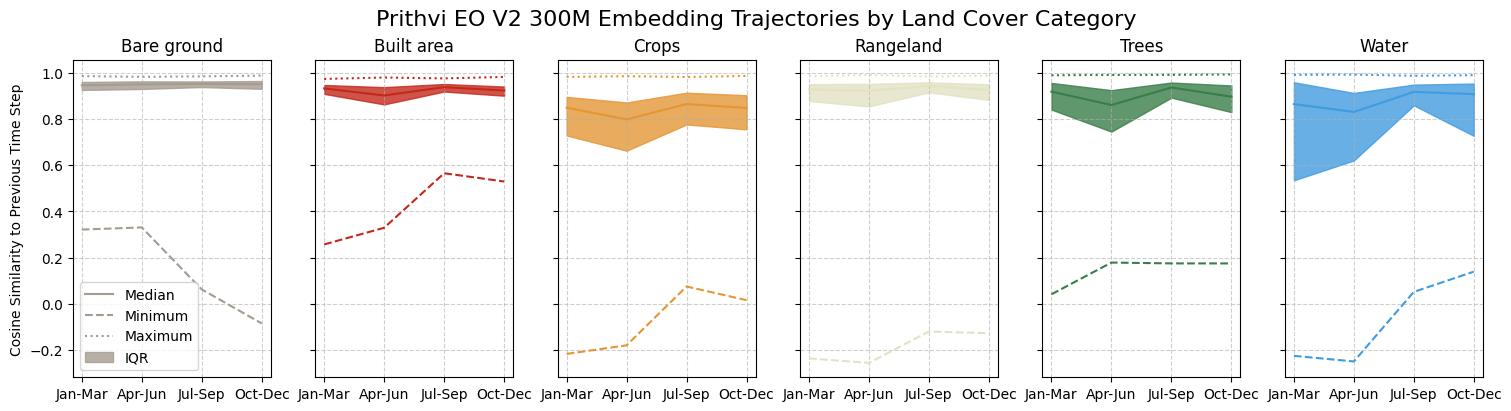

In [19]:
# Get unique categories
categories = chip_gdf['category'].unique()
n_categories = len(categories)

# Determine the grid size for subplots
n_cols = 6
n_rows = (n_categories + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharey=True, constrained_layout=True)
axes = axes.flatten()  # Flatten to a 1D array for easy iteration

similarity_cols = [f"temporalsimilarity_{t}" for t in range(n_timesteps)]
timesteps = np.arange(n_timesteps)

for i, category in enumerate(sorted(categories)):
    ax = axes[i]
    category_df = chip_gdf[chip_gdf['category'] == category]
    category_color = colors_df[category]
    
    # Calculate quartiles for the similarity columns
    quartiles = category_df[similarity_cols].quantile([0.25, 0.5, 0.75])
    q1 = quartiles.loc[0.25]
    median = quartiles.loc[0.5]
    q3 = quartiles.loc[0.75]    
    min = category_df[similarity_cols].min()
    max = category_df[similarity_cols].max()
    
    # Plot the median line
    ax.plot(timesteps, median, label='Median', color=category_color)
    ax.plot(timesteps, min, label="Minimum", color=category_color, linestyle="--")
    ax.plot(timesteps, max, label="Maximum", color=category_color, linestyle=":")
    
    # Shade the interquartile range (IQR)
    ax.fill_between(timesteps, q1, q3, alpha=0.8, color=category_color, label='IQR')
    
    # Set titles, labels, and legend
    ax.set_title(category)
    if i == 0:
        ax.set_ylabel("Cosine Similarity to Previous Time Step")    
        ax.legend()
    ax.set_xticks(timesteps)
    ax.set_xticklabels(timestep_ranges)
    ax.grid(True, linestyle='--', alpha=0.6)
# Add a main title to the figure
fig.suptitle(f'{model_title} Embedding Trajectories by Land Cover Category', fontsize=16)
plt.savefig(figures_dir / f"{model_title_lower}_{perturb_string}_{extraction_strategy_lower}_{embedding_layer_lower}_temporalsimilarity.png", dpi=300)

In [20]:
def construct_thumbnail_paths(row, data_root: Path):
    date_list = row[f"sentinel_2_dates"].split(",")
    id = row["id"]
    path_list = [data_root / f"sentinel_2_{id:06}_{date}.png" for date in date_list]
    return path_list

chip_gdf[f"sentinel_2_thumbnail_paths"] = chip_gdf.apply(
    construct_thumbnail_paths, data_root=data_root, axis=1
)

    


In [12]:
from gelos.plotting import format_lat_lon

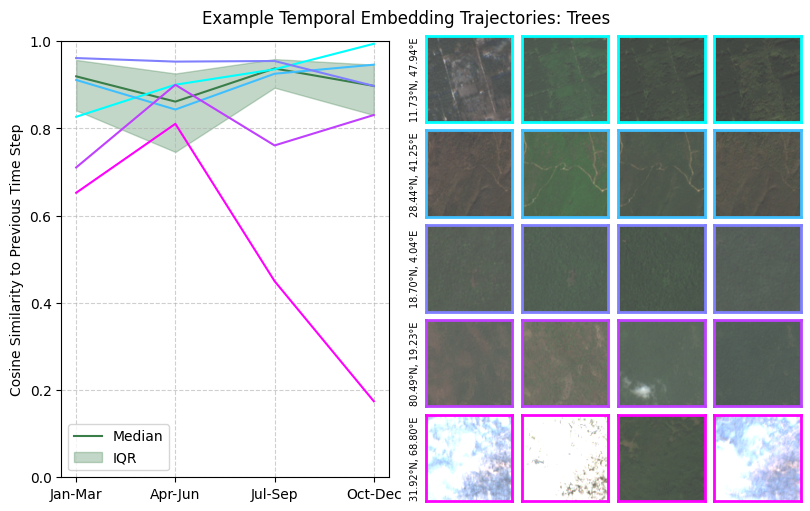

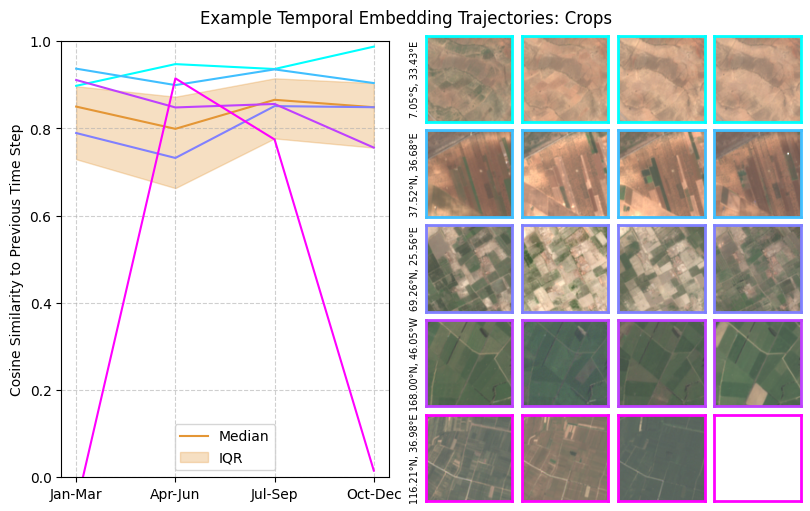

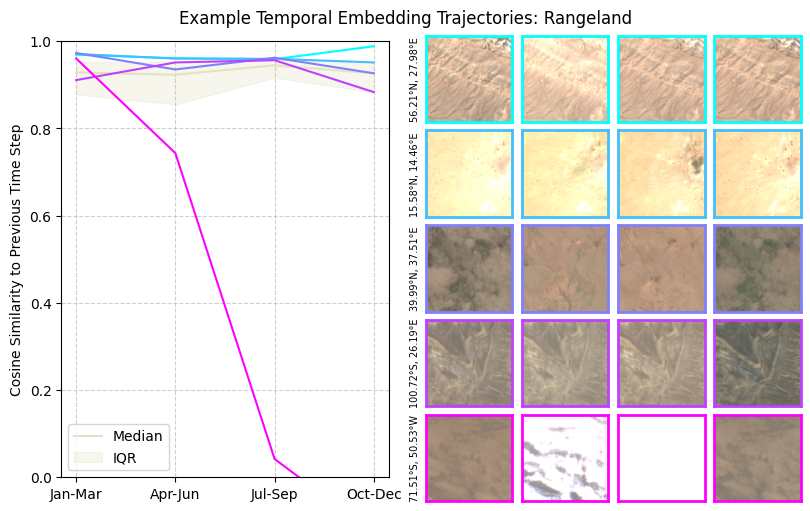

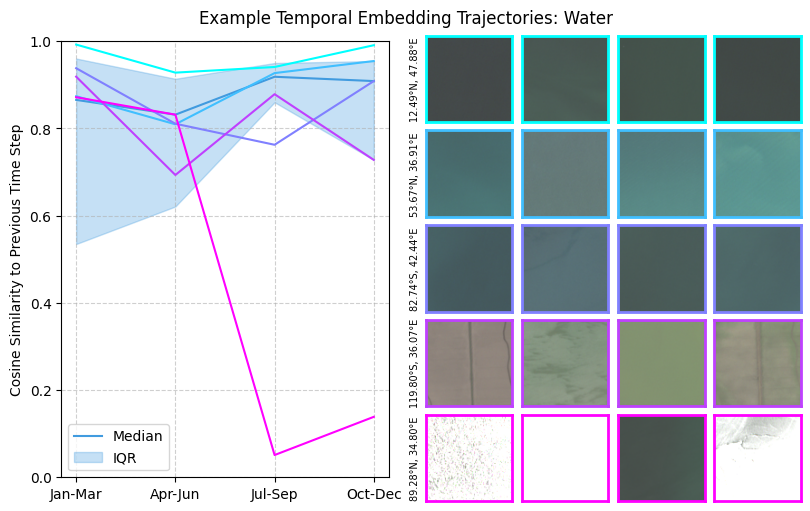

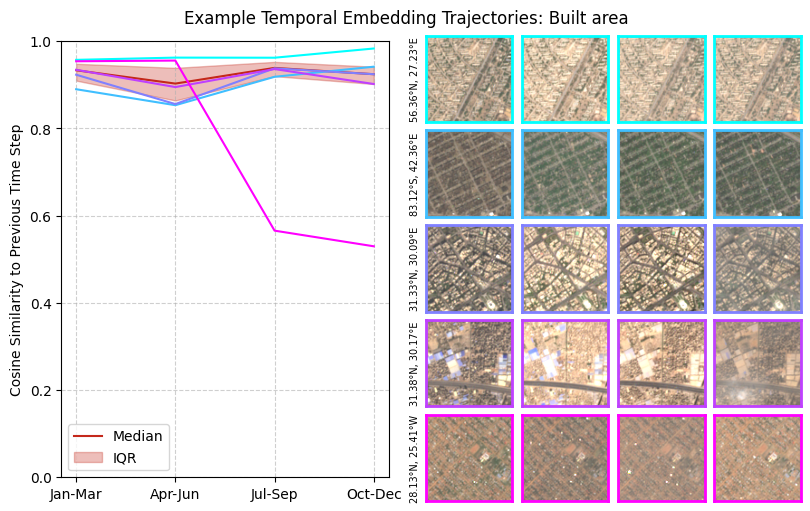

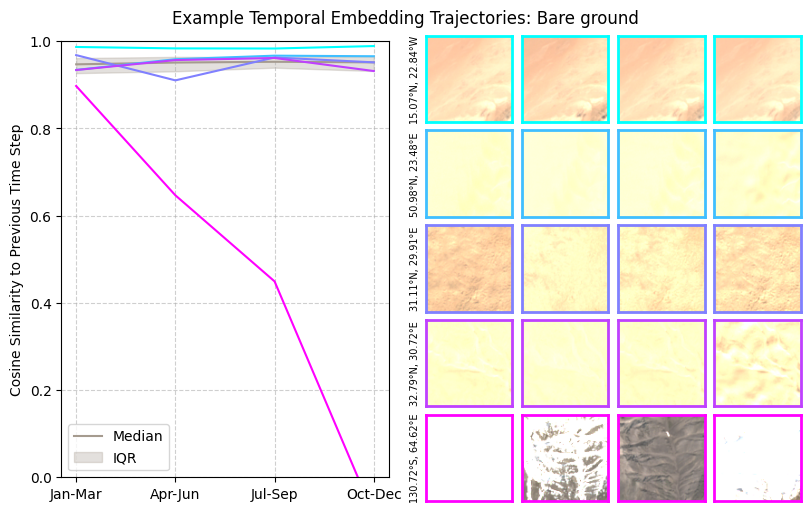

In [24]:

# Get unique categories
categories = chip_gdf['category'].unique()
n_categories = len(categories)

similarity_cols = [f"temporalsimilarity_{t}" for t in range(n_timesteps)]
timesteps = np.arange(n_timesteps)

for category in categories:
    category_df = chip_gdf[chip_gdf['category'] == category]
    category_color = colors_df[category]
    
    # Calculate quartiles for the similarity columns
    quartiles = category_df[similarity_cols].quantile([0.25, 0.5, 0.75])
    q1 = quartiles.loc[0.25].values
    median = quartiles.loc[0.5].values
    q3 = quartiles.loc[0.75].values
    min = category_df[similarity_cols].min().values
    max = category_df[similarity_cols].max().values
    stat_examples = {}
    stats = {
        "max": max,
        "q3": q3,
        "median": median,
        "q1": q1,
        "min": min,
    }

    for name, value in stats.items():
        diff = (category_df["temporalsimilarity_3"] - value[3]).abs()
        stat_examples[name] = diff.idxmin()
    stat_keys = list(stat_examples.keys())
    cmap = plt.get_cmap("cool", len(stat_keys)) 
    colors = {key: cmap(i) for i, key in enumerate(stat_keys)}
    n_cols = n_timesteps
    n_rows = len(stat_examples.keys())

    fig = plt.figure(layout='constrained', figsize=(n_cols * 2, n_rows * 1))
    subfigs = fig.subfigures(1, 2, wspace=0.00)

    quart_ax = subfigs[0].subplots()
    timesteps = np.arange(n_timesteps)
    quart_ax.plot(timesteps, median, color=colors_df[category], label="Median")
    quart_ax.fill_between(timesteps, q1, q3, color=colors_df[category], alpha=0.3, label="IQR")
    for c, (stat, example_idx) in enumerate(stat_examples.items()):
        example_values = chip_gdf.loc[stat_examples[stat], similarity_cols].values
        quart_ax.plot(timesteps, example_values, color=colors[stat])
    quart_ax.set_ylim(0,1)
    quart_ax.set_xticks(timesteps)
    quart_ax.set_xticklabels(timestep_ranges)
    quart_ax.set_ylabel("Cosine Similarity to Previous Time Step")
    quart_ax.grid(True, linestyle="--", alpha=0.6)
    quart_ax.legend()

    thumb_axs = subfigs[1].subplots(n_rows, n_cols)
    for row, (stat, example_idx) in enumerate(stat_examples.items()):
        example_lat, example_lon = chip_gdf.loc[example_idx, ["lat", "lon"]]
        example_thumbs = chip_gdf.loc[example_idx, "sentinel_2_thumbnail_paths"]
        for col, thumb_path in enumerate(example_thumbs):
            # cosine_similarity_value = chip_gdf.loc[stat_examples[stat], similarity_cols].values[col]
            ax = thumb_axs[row, col]
            ax.imshow(Image.open(thumb_path))
            ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
            # ax.set_title(f"{cosine_similarity_value:.2f}")
            for spine in ax.spines.values():
                spine.set_edgecolor(colors[stat])
                spine.set_linewidth(2)
                # spine.set_edgecolor("lightgray")
            if col == 0:
                ax.set_ylabel(format_lat_lon(example_lat, example_lon), rotation=90, ha="center", va="bottom", fontsize=7)
    plt.suptitle(f"Example Temporal Embedding Trajectories: {category}")
    category_lower = category.replace(" ","").lower()
    plt.savefig(figures_dir / f"{model_title_lower}_{perturb_string}_{extraction_strategy_lower}_{embedding_layer_lower}_temporalsimilarity_{category_lower}.png", dpi=300)

            